In [1]:
!nvidia-smi

Thu Apr  4 10:43:09 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 410.79       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN Xp            Off  | 00000000:01:00.0 Off |                  N/A |
| 23%   27C    P8    16W / 250W |      0MiB / 12195MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
IMG_WIDTH = 1400
IMG_HEIGHT = 1400
ROW_SLICE = slice(0, 1400)
COL_SLICE = slice(1000, None)

In [9]:
import os
import sys
import numpy as np

from matplotlib.image import imread
import matplotlib.pyplot as plt
import tensorflow as tf
from UNet import get_unet

In [4]:
sys.path.append("../")

In [5]:
%matplotlib inline

In [16]:
# ih_data dir
#data_dir = "/data/uob/Jordan/"
# deepthought_data_dir
data_dir = "/storage/yw18581/data/"

In [13]:
model1500 = get_unet()
model1500.load_weights(os.path.join(data_dir,"trained_models","retrained_UNet_1000+500epochs.hdf5"))

In [14]:
import os
from UNet import get_unet
from data_loaders_km3 import data_generator, get_n_iterations
from os import path as p
import tensorflow as tf
from tqdm import tqdm
import numpy as np

In [15]:
def inference_step(network_model, test_data_generator, predict_steps):

    y_pred = list()

    for _ in tqdm(range(predict_steps)):
        X_batch, _ = next(test_data_generator)
        Y_batch_pred = network_model.predict_on_batch(X_batch)
        #print(Y_batch_pred.shape)
        y_pred.append(Y_batch_pred)
    y_pred = np.concatenate(y_pred, axis=0)

    return y_pred

In [17]:
TRAIN_VAL_TEST_DIR = os.path.join(data_dir, "train_validation_test")
N_EPOCHS=1500
N_FILES = 1
BATCH_SIZE=3

In [18]:
model = get_unet()
#model.summary()

In [20]:
CHECKPOINT_FOLDER_PATH = os.path.join(data_dir, 'trained_models')
TASK_NAME = 'UNet_training_generator_{}epochs'.format(N_EPOCHS)
TASK_FOLDER_PATH = os.path.join(CHECKPOINT_FOLDER_PATH, TASK_NAME)

In [21]:
if not os.path.exists(TASK_FOLDER_PATH):
    os.makedirs(TASK_FOLDER_PATH)


In [22]:
TRAINING_WEIGHTS_FILEPATH=os.path.join(CHECKPOINT_FOLDER_PATH,'retrained_UNet_1000+500epochs.hdf5')

In [23]:
fname_test = [os.path.join(TRAIN_VAL_TEST_DIR,"Xy_test_dist.npz")]

model.load_weights(TRAINING_WEIGHTS_FILEPATH)
prediction_steps, n_evts_test = get_n_iterations(fname_test, batch_size=BATCH_SIZE)

['/storage/yw18581/data/train_validation_test/Xy_test_dist.npz']
/storage/yw18581/data/train_validation_test/Xy_test_dist.npz
(240, 1400, 1400, 1)


In [24]:
fname_train = [os.path.join(TRAIN_VAL_TEST_DIR,"Xy_train_dist.npz")]
fname_val = [os.path.join(TRAIN_VAL_TEST_DIR,"Xy_val_dist.npz")]

model.load_weights(TRAINING_WEIGHTS_FILEPATH)
prediction_steps_train, n_evts_train = get_n_iterations(fname_train, batch_size=BATCH_SIZE)
prediction_steps_val, n_evts_val = get_n_iterations(fname_val, batch_size=BATCH_SIZE)


['/storage/yw18581/data/train_validation_test/Xy_train_dist.npz']
/storage/yw18581/data/train_validation_test/Xy_train_dist.npz
(768, 1400, 1400, 1)
['/storage/yw18581/data/train_validation_test/Xy_val_dist.npz']
/storage/yw18581/data/train_validation_test/Xy_val_dist.npz
(192, 1400, 1400, 1)


In [25]:
np.load(fname_test[0])['x'].shape

(240, 1400, 1400, 1)

In [16]:
test_data_gen = data_generator(fname_test, batch_size=BATCH_SIZE,
                               ftarget=lambda y: y)

In [16]:
train_data_gen = data_generator(fname_train, batch_size=BATCH_SIZE,
                               ftarget=lambda y: y)

In [17]:
val_data_gen = data_generator(fname_val, batch_size=BATCH_SIZE,
                               ftarget=lambda y: y)

In [17]:
y_pred = inference_step(model, test_data_gen, prediction_steps)

100%|██████████| 80/80 [00:33<00:00,  3.23it/s]


In [18]:
y_pred.shape

(240, 1400, 1400, 1)

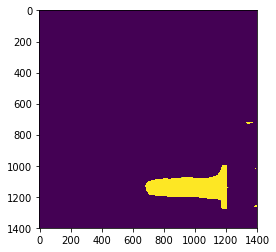

In [20]:
plt.imshow(y_pred[0][...,0])

In [19]:
train_pred = inference_step(model, train_data_gen, prediction_steps_train)

100%|██████████| 256/256 [01:39<00:00,  3.22it/s]


In [20]:
val_pred = inference_step(model, val_data_gen, prediction_steps_val)

100%|██████████| 64/64 [00:26<00:00,  3.26it/s]


In [28]:
x_test_out =np.load(fname_test[0])['x'][...,0]
dist_test_out = np.load(fname_test[0])['dist']

In [ ]:
x_train_out =np.load(fname_train[0])['x'][...,0]
dist_train_out = np.load(fname_train[0])['dist']

In [ ]:
x_val_out =np.load(fname_test[0])['x'][...,0]
dist_val_out = np.load(fname_test[0])['dist']

In [29]:
print(x_out.shape, dist_out.shape)


(240, 1400, 1400) (240,)


In [39]:
np.savez_compressed(os.path.join(TASK_FOLDER_PATH,"Xy_test_predicted_UNet.npz"),
                   x= x_out, y=y_pred[...,0], dist = dist_out )